# Sourcing and Cleaning IMDB Data

In [2]:
#import all programs needed
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#establish connection to imdb database

conn = sqlite3.connect('Phase 1 Project Data/im.db')
cursor_obj = conn.cursor()

In [5]:
#create movie_basics dataframe and examine the data 
movie_basics_df = pd.read_sql('''
    SELECT *
    FROM movie_basics
    ''', conn)

movie_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


Notes on movie_basics: Missing data in the original_title column (<1%), genres (4%) and runtime_minutes (21%). Nulls in title and genre are better to drop, while runtime should be inputed based on mean or median. 

Data types make sense 

Genres is a string containing multiple genres. Needs to be split into multiple columns. Possibly use a primary/secondary/tertiary genre structure based on the order it is listed in the string 

In [13]:
#create movie_ratings dataframe and examine the data
movie_ratings_df = pd.read_sql('''
    SELECT *
    FROM movie_ratings
    ''', conn)

movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


Notes on movie_rating dataframe: only two columns. Wide range in the number of votes, possibly need to create a minimum vote count to be included in the ratings analysis (mean - 3*std).

Possible outliers included. The minimum average rating is more than 3 standard deviations away from the mean. The std of the numvotes column is an order of magnitude greater than the mean.

Smaller than the movie_basics dataframe so it would make sense to merge left onto the basics df 

In [15]:
#create director dataframe and examine data
director_df = pd.read_sql('''
    SELECT *
    FROM directors
    ''', conn)

director_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


Only contains the person_id for the director, if I want names then I will have to merge with the persons dataframe. Otherwise looks good with no null values 

In [16]:
#create persons dataframe and examine data
persons_df = pd.read_sql('''
    SELECT *
    FROM persons
    ''', conn)

persons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


Need to concat with directors df in order to create a full list of movie ids with director names 

In [34]:
#merge director and persons dataframes to create a unified df of director credits with names 

director_persons_df = pd.merge(director_df, persons_df, how = 'left', on = 'person_id')
director_persons_df.info()

#remove duplicates before merging with movie_basics_ratings

director_persons_df.drop_duplicates(subset = 'movie_id', inplace = True)
director_persons_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 291174 entries, 0 to 291173
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            291174 non-null  object 
 1   person_id           291174 non-null  object 
 2   primary_name        291171 non-null  object 
 3   birth_year          68608 non-null   float64
 4   death_year          1738 non-null    float64
 5   primary_profession  290187 non-null  object 
dtypes: float64(2), object(4)
memory usage: 15.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 140417 entries, 0 to 291173
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            140417 non-null  object 
 1   person_id           140417 non-null  object 
 2   primary_name        140416 non-null  object 
 3   birth_year          30609 non-null   float64
 4   death_year          85

In [31]:
#merge movie ratings and movie basics dfs together 

movie_basics_ratings_df = pd.merge(movie_basics_df, movie_ratings_df, how ='left', on = 'movie_id')
movie_basics_ratings_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 146144 entries, 0 to 146143
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
 6   averagerating    73856 non-null   float64
 7   numvotes         73856 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 10.0+ MB


In [121]:
#create final IMDB database by merging movie_basics_ratings_df left onto director_persons_df 
imdb_df = pd.merge(director_persons_df, movie_basics_ratings_df, how = 'left', on = 'movie_id')

In [122]:
#clean up the IMDB dataframe (rename primary name, remove birth year and death year, remove rows with null name, primary profession and genres)
imdb_df.rename(columns = {'primary_name':'director_name'}, inplace = True)
imdb_df.drop(columns = ['birth_year', 'death_year'], axis = 1, inplace = True)
imdb_df.dropna(subset = ['director_name', 'primary_profession', 'original_title', 'genres'], axis = 0, inplace = True)

In [123]:
#Remove potential duplicate titles by sorting for and removing rows with duplicate titles and directors. Keep the row with highest number of votes
imdb_df.sort_values(by = ['primary_title', 'director_name', 'numvotes'], ascending = [True, True, False], inplace = True)
imdb_df.drop_duplicates(subset = ['primary_title', 'director_name'], keep = 'first', inplace = True)


In [134]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136409 entries, 8464 to 72703
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            136409 non-null  object 
 1   person_id           136409 non-null  object 
 2   director_name       136409 non-null  object 
 3   primary_profession  136409 non-null  object 
 4   primary_title       136409 non-null  object 
 5   original_title      136409 non-null  object 
 6   start_year          136409 non-null  int64  
 7   runtime_minutes     109720 non-null  float64
 8   genres              136409 non-null  object 
 9   averagerating       72345 non-null   float64
 10  numvotes            72345 non-null   float64
dtypes: float64(3), int64(1), object(7)
memory usage: 12.5+ MB


# Combining IMDB and Budget Data 

In [202]:
budget_df = pd.read_csv('budget_df.csv')

In [203]:
#Merge IMDB with Budget. Create a subset of only movies with matching release years

merged_df = budget_df.merge(imdb_df, how = 'left', left_on = 'movie', right_on = 'primary_title')
imdb_budget_df = merged_df[merged_df['start_year'] == merged_df['release_year']]
imdb_budget_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1536 entries, 1 to 7075
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1536 non-null   int64  
 1   id                  1536 non-null   int64  
 2   release_date        1536 non-null   object 
 3   movie               1536 non-null   object 
 4   production_budget   1536 non-null   int64  
 5   domestic_gross      1536 non-null   int64  
 6   worldwide_gross     1536 non-null   int64  
 7   profit              1536 non-null   int64  
 8   release_month       1536 non-null   int64  
 9   foreign_gross       1536 non-null   int64  
 10  release_year        1536 non-null   int64  
 11  ROI                 1536 non-null   float64
 12  movie_id            1536 non-null   object 
 13  person_id           1536 non-null   object 
 14  director_name       1536 non-null   object 
 15  primary_profession  1536 non-null   object 
 16  primar

In [204]:
#Separate genres into individual rows
imdb_budget_df['genres'] = imdb_budget_df['genres'].apply(lambda x: str(x).split(','))
imdb_budget_df = imdb_budget_df.explode('genres')

<ipython-input-204-009832f8539f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_budget_df['genres'] = imdb_budget_df['genres'].apply(lambda x: str(x).split(','))


# Use imdb_budget to find the most popular genres for peak months 

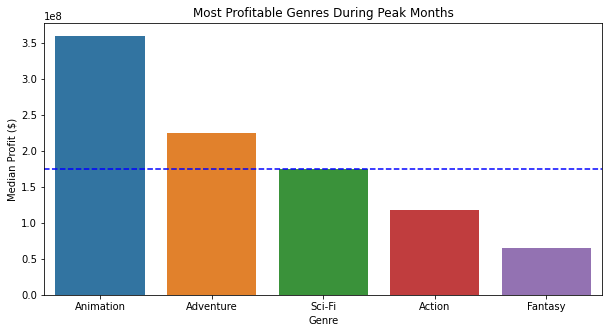

In [354]:
imdb_budget_df = imdb_budget_df[imdb_budget_df['worldwide_gross'] != 0]
filtered_df = imdb_budget_df.loc[imdb_budget_df['release_month'].isin([6,7,11])]
grouped_df = filtered_df.groupby(['genres']).median().sort_values(by=['profit'], ascending=[False]).reset_index()
top_5_genres_df = grouped_df.head(5)
median_profit = top_5_genres_df['profit'].median()
fig , ax = plt.subplots(figsize = (10,5))
sns.barplot(x = 'genres', y ='profit', data = top_5_genres_df);
ax.set_title('Most Profitable Genres During Peak Months')
ax.set_ylabel('Median Profit ($)')
ax.set_xlabel('Genre')
ax.axhline(median_profit, color = 'b', linestyle = 'dashed')
plt.savefig('genrebyprofit.png');

# Explore Relationship Between Directors and Box Office Performance  

In [306]:
imdb_budget_df.corr()

,Unnamed: 0,id,production_budget,domestic_gross,worldwide_gross,profit,release_month,foreign_gross,release_year,ROI,start_year,runtime_minutes,averagerating,numvotes
Unnamed: 0,1.000000,0.016446,-0.783847,-0.562523,-0.588083,-0.485742,0.102067,-0.575063,-0.039833,0.119253,-0.039833,-0.330671,-0.148698,-0.447921
id,0.016446,1.000000,-0.074331,-0.028216,-0.044472,-0.032460,-0.021660,-0.051180,0.037126,0.047160,0.037126,-0.011324,0.010975,-0.021783
production_budget,-0.783847,-0.074331,1.000000,0.700290,0.776437,0.651222,-0.078065,0.782021,0.057002,-0.051811,0.057002,0.340838,0.188430,0.528812
domestic_gross,-0.562523,-0.028216,0.700290,1.000000,0.944517,0.938676,-0.070266,0.871755,0.079655,0.085797,0.079655,0.278720,0.318651,0.656201
worldwide_gross,-0.588083,-0.044472,0.776437,0.944517,1.000000,0.983880,-0.052415,0.984315,0.087996,0.073626,0.087996,0.296808,0.298976,0.642436
profit,-0.485742,-0.032460,0.651222,0.938676,0.983880,1.000000,-0.040966,0.963407,0.089790,0.103364,0.089790,0.260722,0.306624,0.623739
release_month,0.102067,-0.021660,-0.078065,-0.070266,-0.052415,-0.040966,1.000000,-0.040442,-0.070339,-0.009792,-0.070339,0.110116,0.173768,0.026140
foreign_gross,-0.575063,-0.051180,0.782021,0.871755,0.984315,0.963407,-0.040442,1.000000,0.088473,0.063740,0.088473,0.293007,0.274813,0.605814
release_year,-0.039833,0.037126,0.057002,0.079655,0.087996,0.089790,-0.070339,0.088473,1.000000,0.034179,1.000000,0.118870,0.022838,-0.115615
ROI,0.119253,0.047160,-0.051811,0.085797,0.073626,0.103364,-0.009792,0.063740,0.034179,1.000000,0.034179,-0.057355,-0.011420,0.060018


In [230]:
# import plotly.express as px 
# px.scatter(imdb_budget_dedupe_df, x ='profit', y = 'ROI', hover_data = ['director_name'])

In [244]:
# genres_subset = imdb_budget_df.loc[imdb_budget_df['genres'].isin(['Animation', 'Adventure', 'Sci-Fi'])].reset_index()
# genres_subset['ROI_Performance'] = genres_subset['ROI'].apply(lambda x: "High" if x > genres_subset['ROI'].quantile(q = .75) else 'Low')
# genres_subset['Profit_Performance'] = genres_subset['profit'].apply(lambda x: "High" if x > genres_subset['profit'].quantile(q = .75) else 'Low')

In [ ]:
# grouped_subset_genre = genres_subset.groupby(['Profit_Performance', 'ROI_Performance'])['director_name'].agg(list)
# short_list = grouped_subset_genre[0] 

In [351]:
genres_subset = imdb_budget_df.loc[imdb_budget_df['genres'].isin(['Animation'])].reset_index()
genres_subset.drop_duplicates(subset = 'primary_title', inplace = True)
is_multi = genres_subset['director_name'].value_counts()>1
multi_director_list = genres_subset[genres_subset['director_name'].isin(is_multi[is_multi].index)]
profit_shortlist = multi_director_list.groupby('director_name').median().sort_values('profit', ascending = False).head(10)
profit_shortlist.reset_index()

,director_name,index,Unnamed: 0,id,production_budget,domestic_gross,worldwide_gross,profit,release_month,foreign_gross,release_year,ROI,start_year,runtime_minutes,averagerating,numvotes
0,Pierre Coffin,791.0,672.0,50.0,74000000.0,336045770.0,975216835.0,899216835.0,7.0,607151450.0,2013.0,1183.180046,2013.0,95.0,7.40,344230.0
1,Lee Unkrich,82.5,73.5,24.5,187500000.0,312365447.5,933443811.5,745943811.5,8.5,621078364.0,2013.5,395.222195,2013.5,104.0,8.35,479706.0
2,Mike Thurmeier,451.0,382.0,33.0,100000000.0,112692425.5,640960909.5,540960909.5,7.0,528268484.0,2014.0,554.537465,2014.0,91.0,6.15,112266.5
3,Dean DeBlois,262.5,226.5,77.5,137000000.0,168897362.0,566922276.5,429922276.5,4.0,398024914.5,2016.5,313.189200,2016.5,103.0,7.70,169487.0
4,Genndy Tartakovsky,637.0,541.0,77.0,80000000.0,167500092.0,469500298.0,389500298.0,9.0,299800188.0,2015.0,486.875372,2015.0,91.0,6.70,92905.0
5,Tom McGrath,293.0,246.0,71.0,130000000.0,175003033.0,510878762.0,385878762.0,6.0,335875729.0,2012.0,308.703010,2012.0,95.0,6.80,146858.0
6,Chris Sanders,197.0,177.0,28.0,150000000.0,202374828.5,533969708.5,383969708.5,3.0,331594880.0,2011.5,262.208471,2011.5,98.0,7.65,393999.0
7,Carlos Saldanha,374.0,313.0,46.0,111000000.0,131538435.0,487519809.0,362846291.0,4.0,343900000.0,2014.0,279.112532,2014.0,101.0,6.70,72209.0
8,Raja Gosnell,386.5,325.5,26.5,110000000.0,106815971.0,456148423.0,346148423.0,7.0,349332452.0,2012.0,314.680385,2012.0,104.0,5.45,55903.0
9,Mike Mitchell,483.5,410.0,61.0,102500000.0,158350548.0,346619328.5,253050852.0,8.0,203212102.0,2013.0,328.324368,2013.0,92.0,6.15,53427.5


In [352]:
roi_shortlist = multi_director_list.groupby('director_name').median().sort_values('ROI', ascending = False).head(10)
roi_shortlist.reset_index()

,director_name,index,Unnamed: 0,id,production_budget,domestic_gross,worldwide_gross,profit,release_month,foreign_gross,release_year,ROI,start_year,runtime_minutes,averagerating,numvotes
0,Pierre Coffin,791.0,672.0,50.0,74000000.0,336045770.0,975216835.0,899216835.0,7.0,607151450.0,2013.0,1183.180046,2013.0,95.0,7.40,344230.0
1,Mike Thurmeier,451.0,382.0,33.0,100000000.0,112692425.5,640960909.5,540960909.5,7.0,528268484.0,2014.0,554.537465,2014.0,91.0,6.15,112266.5
2,Genndy Tartakovsky,637.0,541.0,77.0,80000000.0,167500092.0,469500298.0,389500298.0,9.0,299800188.0,2015.0,486.875372,2015.0,91.0,6.70,92905.0
3,Lee Unkrich,82.5,73.5,24.5,187500000.0,312365447.5,933443811.5,745943811.5,8.5,621078364.0,2013.5,395.222195,2013.5,104.0,8.35,479706.0
4,Mike Mitchell,483.5,410.0,61.0,102500000.0,158350548.0,346619328.5,253050852.0,8.0,203212102.0,2013.0,328.324368,2013.0,92.0,6.15,53427.5
5,Raja Gosnell,386.5,325.5,26.5,110000000.0,106815971.0,456148423.0,346148423.0,7.0,349332452.0,2012.0,314.680385,2012.0,104.0,5.45,55903.0
6,Dean DeBlois,262.5,226.5,77.5,137000000.0,168897362.0,566922276.5,429922276.5,4.0,398024914.5,2016.5,313.189200,2016.5,103.0,7.70,169487.0
7,Tom McGrath,293.0,246.0,71.0,130000000.0,175003033.0,510878762.0,385878762.0,6.0,335875729.0,2012.0,308.703010,2012.0,95.0,6.80,146858.0
8,Carlos Saldanha,374.0,313.0,46.0,111000000.0,131538435.0,487519809.0,362846291.0,4.0,343900000.0,2014.0,279.112532,2014.0,101.0,6.70,72209.0
9,Chris Sanders,197.0,177.0,28.0,150000000.0,202374828.5,533969708.5,383969708.5,3.0,331594880.0,2011.5,262.208471,2011.5,98.0,7.65,393999.0


In [353]:
final_short_list = profit_shortlist.loc[profit_shortlist['director_name'] in roi_shortlist['director_name']]

KeyError: 'director_name'

# How does budget correlate with profit

In [345]:
genres_subset.corr()

,index,Unnamed: 0,id,production_budget,domestic_gross,worldwide_gross,profit,release_month,foreign_gross,release_year,ROI,start_year,runtime_minutes,averagerating,numvotes
index,1.000000,0.999891,-0.159101,-0.767159,-0.492458,-0.530675,-0.440302,0.084170,-0.519220,0.136665,-0.210485,0.136665,-0.371989,-0.294044,-0.387168
Unnamed: 0,0.999891,1.000000,-0.159278,-0.773146,-0.495761,-0.534616,-0.443516,0.082156,-0.523268,0.139423,-0.209497,0.139423,-0.378560,-0.297921,-0.390823
id,-0.159101,-0.159278,1.000000,0.069304,0.078483,0.064199,0.057767,-0.183093,0.052565,0.028874,0.044942,0.028874,-0.035910,0.067660,0.059020
production_budget,-0.767159,-0.773146,0.069304,1.000000,0.595354,0.616128,0.490269,-0.019365,0.590040,-0.251099,0.061699,-0.251099,0.509718,0.448655,0.582797
domestic_gross,-0.492458,-0.495761,0.078483,0.595354,1.000000,0.926790,0.911526,-0.107243,0.830933,-0.028755,0.674567,-0.028755,0.448783,0.478256,0.706506
worldwide_gross,-0.530675,-0.534616,0.064199,0.616128,0.926790,1.000000,0.988558,-0.080613,0.979063,-0.073782,0.756474,-0.073782,0.424791,0.450447,0.688582
profit,-0.440302,-0.443516,0.057767,0.490269,0.911526,0.988558,1.000000,-0.085494,0.970386,-0.033556,0.825262,-0.033556,0.372438,0.412522,0.650341
release_month,0.084170,0.082156,-0.183093,-0.019365,-0.107243,-0.080613,-0.085494,1.000000,-0.061294,-0.237753,-0.102431,-0.237753,0.001295,-0.006665,-0.029145
foreign_gross,-0.519220,-0.523268,0.052565,0.590040,0.830933,0.979063,0.970386,-0.061294,1.000000,-0.093713,0.755012,-0.093713,0.386038,0.408071,0.637129
release_year,0.136665,0.139423,0.028874,-0.251099,-0.028755,-0.073782,-0.033556,-0.237753,-0.093713,1.000000,0.063259,1.000000,0.017029,-0.087989,-0.350505


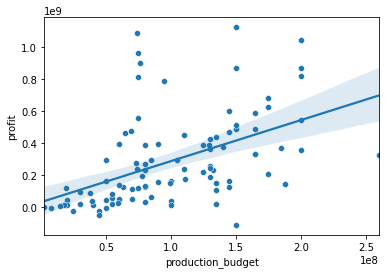

,production_budget,profit
production_budget,1.000000,0.490269
profit,0.490269,1.000000


In [343]:
ax = sns.scatterplot(x = 'production_budget', y = 'profit', data = genres_subset)
line = sns.regplot(data= genres_subset, x="production_budget", y='profit', scatter=False, ax=ax)
plt.show();
genres_subset.loc[: , ["production_budget",'profit']].corr()